In [44]:
from os import path
import pandas as pd
from corputil import ListCorpus
from corputil.utils import load_stopwords
from gensim.models import LdaMulticore
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary

stopwords = load_stopwords(path.join('data', 'german.txt'))

In [45]:
num_topics = 100
chunksize, iterations, passes = 500, 100, 10
labels = ['2015KW44', '2015KW45', '2015KW46', '2015KW47', '2015KW48', '2015KW49', '2015KW50', '2015KW51']
files = [path.join('data', 'CurrentNews', 'RAW_{}.csv').format(label) for label in labels[:1]]
output_model = [path.join('models', 'lda', '{}.lda').format(label) for label in labels]
output_dict = path.join('models', 'lda', 'Words.dict')
output_bigram = path.join('models', 'lda', 'Bigram.phrase')

In [46]:
dfs = [pd.read_csv(file, sep='|', encoding='utf-8') for file in files]

In [47]:
corpora = [ListCorpus(list(df.loc[:, 'text'])) for df in dfs]

In [48]:
def create_phrase():
    sentences = [sentence for corpus in corpora for sentence in corpus.sentences_token(stopwords=stopwords)]
    bigram = Phrases(sentences)
    return bigram


def create_dict():
    docs = [bigram[doc] for corpus in corpora for doc in corpus.doc_token(stopwords)]
    dictionary = Dictionary(docs)
    dictionary.filter_extremes()
    dictionary.compactify()
    return dictionary


def train_lda(corpus):
    bow = [dictionary.doc2bow(bigram[doc]) for doc in corpus]
    lda = LdaMulticore(bow, id2word=dictionary, chunksize=chunksize, #batch=True,
                       num_topics=num_topics, workers=2, passes=passes, iterations=iterations)
    return bow, lda

In [49]:
bigram = create_phrase()
dictionary = create_dict()

models = []
docs = []

for i, corpus in enumerate(corpora):
    mmCorpus, model = train_lda(corpus.doc_token(stopwords=stopwords))
    models.append(model)
    docs.append(mmCorpus)
    model.save(output_model[i])

bigram.save(output_bigram)
dictionary.save(output_dict)

## Topic Chains

In [ ]:
import numpy as np
from gensim.matutils import sparse2full

In [ ]:
def hellinger(vec1, vec2, model1, model2):
    dense1 = sparse2full(vec1, model1.num_topics)
    dense2 = sparse2full(vec2, model2.num_topics)
    return np.sqrt(0.5 * ((np.sqrt(dense1) - np.sqrt(dense2))**2).sum())

## Visualization

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)
matplotlib.rcParams['axes.titlesize'] = 24

from sklearn.manifold import TSNE
from sklearn.externals import joblib
from gensim.matutils import sparse2full

vectorizer = joblib.load(path.join('models', 'classifier', 'RAW_Vectorizer.pkl'))
classifier = joblib.load(path.join('models', 'classifier', 'RAW_Classifier.pkl'))

colors = {'Politics': 'red', 
          'Economy': 'blue', 
          'Science': 'green', 
          'Car': 'teal', 
          'Education': 'lime',  
          'Culture': 'purple', 
          'Society': 'orange', 
          'Travel': 'magenta', 
          'Sport': 'brown', 
          'Technology': 'cyan'}

In [50]:
model = models[0]
doc = docs[0]

tfidf = vectorizer.transform(dfs[0]['text'])
bow = [sparse2full(d, model.num_topics) for d in model[doc]]
tags = classifier.predict(tfidf)
labels = [colors[tag] for tag in tags]
reduced = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(bow)
df = pd.DataFrame(reduced)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 8481
[t-SNE] Computed conditional probabilities for sample 2000 / 8481
[t-SNE] Computed conditional probabilities for sample 3000 / 8481
[t-SNE] Computed conditional probabilities for sample 4000 / 8481
[t-SNE] Computed conditional probabilities for sample 5000 / 8481
[t-SNE] Computed conditional probabilities for sample 6000 / 8481
[t-SNE] Computed conditional probabilities for sample 7000 / 8481
[t-SNE] Computed conditional probabilities for sample 8000 / 8481
[t-SNE] Computed conditional probabilities for sample 8481 / 8481
[t-SNE] Mean sigma: 0.000000
[t-SNE] Iteration 25: error = 1.3779252, gradient norm = 0.0025294
[t-SNE] Iteration 50: error = 1.3699996, gradient norm = 0.0089331
[t-SNE] Iteration 75: error = 1.2747658, gradient norm = 0.0025338
[t-SNE] Iteration 100: error = 1.2493968, gradient norm = 0.0021825
[t-SNE] Error after 100 i

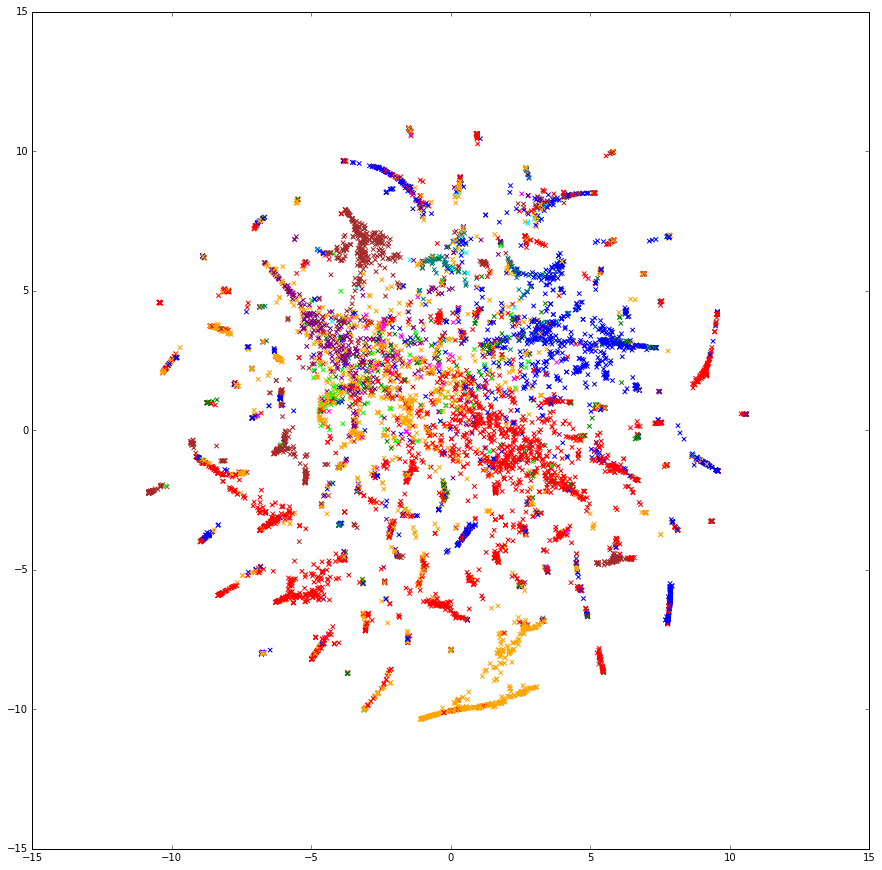

In [51]:
plt.scatter(df[0], df[1], c=labels, marker='x')

In [52]:
model.show_topics(-1)

[(0,
  '0.099*china + 0.050*elias + 0.023*chinas + 0.023*peking + 0.011*iran + 0.010*teheran + 0.010*uno + 0.009*boeing + 0.007*besuch + 0.006*aufgeklärt'),
 (1,
  '0.022*absturz + 0.011*mitarbeiter + 0.008*fluggesellschaften + 0.007*air_france + 0.006*unternehmen + 0.006*stadt + 0.004*staatstrauer + 0.004*frankfurt + 0.004*boden + 0.004*unglück'),
 (2,
  '0.022*all_blacks + 0.010*flüchtlinge + 0.008*wallabies + 0.006*neuseeländer + 0.006*johanna_uekermann + 0.006*festgenommene + 0.006*angegriffen_verletzt + 0.006*twickenham + 0.006*juso_vorsitzende + 0.005*fulda'),
 (3,
  '0.014*yasmin_fahimi + 0.007*us + 0.006*tod + 0.006*nähe + 0.006*platz + 0.005*gold + 0.005*wild + 0.005*hieß + 0.005*york + 0.005*leipzig'),
 (4,
  '0.023*erde + 0.015*forscher + 0.011*wasser + 0.009*abgebrochen + 0.008*meter + 0.008*kilometern + 0.008*asteroid + 0.008*planeten + 0.008*kilometer + 0.006*nasa'),
 (5,
  '0.012*ankara + 0.012*torwart + 0.011*bremer + 0.009*prokurdische_hdp + 0.009*hoffnung + 0.008*tayy